In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial 
from torch import tensor

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

### Create the data

In [3]:
n_clusters = 6
n_samples = 250

In [4]:
centroids = torch.rand(n_clusters,2)*70-30

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [6]:
def sample(m,n_samples=n_samples):
    return MultivariateNormal(m,torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [60]:
data = torch.cat(([sample(m) for m in centroids]),dim=0)
data.shape

torch.Size([1500, 2])

### Plotting the data and centroids

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: 
        _,ax = plt.subplots()
    for i,centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0],samples[:,1],s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

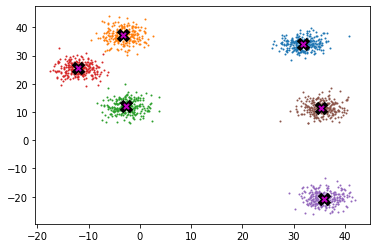

In [9]:
plot_data(centroids, data, n_samples)

In [10]:
def gaussian(d, bw): 
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [11]:
X = data.clone()
x = X[0]
x.shape,X.shape

(torch.Size([2]), torch.Size([1500, 2]))

In [12]:
dist = (x-X).pow(2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [13]:
weights = gaussian(dist, 2.5)
weights.shape

torch.Size([1500])

In [14]:
(weights[:,None] * X).sum(0)

tensor([483.806, 508.394])

In [15]:
def one_update(X):
    for i,x in enumerate(X):
        dist = (x-X).pow(2).sum(1).sqrt()
        weights = gaussian(dist, 2.5)
        X[i] = (weights[:,None] * X).sum(0)/weights.sum()
    return X

In [16]:
def mean_shift(data,n_iter=5):
    X = data.clone()
    for _ in range(n_iter):
        X = one_update(X)
    return X

In [17]:
%time X=mean_shift(data)

CPU times: user 662 ms, sys: 0 ns, total: 662 ms
Wall time: 662 ms


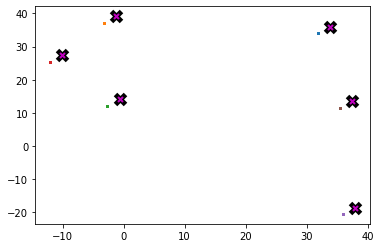

In [18]:
plot_data(centroids+2, X, n_samples)

### Animation

In [19]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [20]:
def do_one(d):
    x = None
    if d:
        x= one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [21]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

### Accelerate with GPU

In [22]:
X = data.clone()
x = X[:5]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [23]:
x[:,None].shape,X[None].shape

(torch.Size([5, 1, 2]), torch.Size([1, 1500, 2]))

In [24]:
dist = (x[:,None]-X[None]).pow(2).sum(2).sqrt()
dist[:8],dist.shape

(tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
         [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
         [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
         [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
         [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]]),
 torch.Size([5, 1500]))

In [25]:
weights = gaussian(dist,2.5)
weights.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [26]:
weights.unsqueeze(2).shape,X.unsqueeze(0).shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [27]:
(weights.unsqueeze(2) * X.unsqueeze(0)).sum(1)

tensor([[483.806, 508.394],
        [635.136, 701.815],
        [427.910, 435.077],
        [643.860, 710.631],
        [322.766, 329.867]])

In [28]:
weights@X

tensor([[483.806, 508.394],
        [635.136, 701.815],
        [427.910, 435.077],
        [643.860, 710.632],
        [322.766, 329.867]])

In [29]:
div = weights.sum(1,keepdim=True)
div.shape

torch.Size([5, 1])

In [30]:
slice(0,5)

slice(0, 5, None)

In [31]:
def mean_shift(data,bs=500):
    X = data.clone()
    n=len(data)
    for _ in range(5):
        for i in range(0, n, bs):
            s = slice(i,min(i+bs,n))
            x = X[s]
            dist = dist = (x[:,None]-X[None]).pow(2).sum(2).sqrt()
            weights = gaussian(dist,2.5)
            X[s]= (weights@X)/weights.sum(1,keepdim=True)
    return X

In [32]:
data = data.cuda()

In [33]:
X = mean_shift(data).cpu()

In [34]:
%time _=mean_shift(data,1250).cpu()

CPU times: user 4.21 ms, sys: 75 µs, total: 4.29 ms
Wall time: 3.63 ms


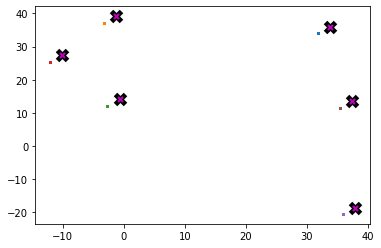

In [35]:
plot_data(centroids+2, X, n_samples)

### K Means

In [36]:
data = torch.cat(([sample(m) for m in centroids]),dim=0)
X = data.clone()

In [37]:
r,c = data.shape[0],data.shape[1]

In [38]:
R = torch.zeros(r,n_clusters)
indices = torch.randint(low=0,high=r,size=(n_clusters,))
clusters = X[indices]

In [39]:
x = X[:5]
x.shape,clusters.shape

(torch.Size([5, 2]), torch.Size([6, 2]))

In [40]:
x.unsqueeze(1).shape,clusters.unsqueeze(0).shape

(torch.Size([5, 1, 2]), torch.Size([1, 6, 2]))

In [41]:
dist = (x.unsqueeze(1) - clusters.unsqueeze(0)).pow(2).sum(2).sqrt()
dist

tensor([[54.304, 43.422, 36.504, 42.852,  4.511, 24.498],
        [55.296, 41.058, 32.664, 40.139,  1.547, 25.705],
        [49.511, 36.911, 33.553, 36.579,  7.428, 20.104],
        [51.131, 38.909, 34.171, 38.466,  5.718, 21.533],
        [52.258, 40.470, 34.880, 39.972,  4.806, 22.554]])

In [42]:
dist.argmin(dim=1)

tensor([4, 4, 4, 4, 4])

In [43]:
dist.sort()

torch.return_types.sort(
values=tensor([[ 4.511, 24.498, 36.504, 42.852, 43.422, 54.304],
        [ 1.547, 25.705, 32.664, 40.139, 41.058, 55.296],
        [ 7.428, 20.104, 33.553, 36.579, 36.911, 49.511],
        [ 5.718, 21.533, 34.171, 38.466, 38.909, 51.131],
        [ 4.806, 22.554, 34.880, 39.972, 40.470, 52.258]]),
indices=tensor([[4, 5, 2, 3, 1, 0],
        [4, 5, 2, 3, 1, 0],
        [4, 5, 2, 3, 1, 0],
        [4, 5, 2, 3, 1, 0],
        [4, 5, 2, 3, 1, 0]]))

In [44]:
R

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [45]:
r1 = R[:5].clone()
r1

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [46]:
indices = dist.argmin(dim=1)
indices

tensor([4, 4, 4, 4, 4])

In [47]:
row_indices = torch.arange(indices.size(0))  # Creates tensor [0, 1, 2, 3, 4]
r1[row_indices, indices] = 1

In [48]:
r1

tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.]])

In [49]:
r1.t().unsqueeze(2).shape,x.unsqueeze(0).shape

(torch.Size([6, 5, 1]), torch.Size([1, 5, 2]))

In [50]:
# updating the clusters
(r1.t().unsqueeze(2) * x.unsqueeze(0)).sum(1)

tensor([[  0.000,   0.000],
        [  0.000,   0.000],
        [  0.000,   0.000],
        [  0.000,   0.000],
        [156.261, 167.190],
        [  0.000,   0.000]])

In [51]:
r1.t()@x

tensor([[  0.000,   0.000],
        [  0.000,   0.000],
        [  0.000,   0.000],
        [  0.000,   0.000],
        [156.261, 167.190],
        [  0.000,   0.000]])

In [52]:
r1.t().shape,x.shape

(torch.Size([6, 5]), torch.Size([5, 2]))

In [53]:
r1.t().sum(1,keepdim=True).shape

torch.Size([6, 1])

In [105]:
def k_means(data, clusters, max_iter=100, epsilon=1e-12):
    n_clusters = clusters.shape[0]  # Number of clusters
    r, c = data.shape  # Number of data points and features
    
    previous_cluster = torch.zeros_like(clusters)  
    cur_iter = 0
    X = data.clone()
    
    while torch.norm(previous_cluster - clusters) >= epsilon and cur_iter < max_iter:
        previous_cluster = clusters.clone()  # Clone to prevent reference issues

        # Step 1: Compute distances
        dist = (X.unsqueeze(1) - clusters.unsqueeze(0)).pow(2).sum(2).sqrt()
        
        # Step 2: Assign each data point to the closest cluster
        indices = dist.argmin(dim=1)  # Cluster assignment
        R = torch.zeros(r, n_clusters, device=data.device)  # One-hot cluster assignment
        R[torch.arange(r), indices] = 1

        # Step 3: Compute new cluster centroids
        div = R.T.sum(1, keepdim=True)  # Sum of points in each cluster
        clusters = (R.T @ X) / div  # Update centroids correctly

        cur_iter += 1

    return clusters


In [77]:
indices = torch.randperm(r)[:n_clusters]  # Selects n_clusters unique indices
clusters = X[indices]  # Picks those points as initial cluster centers
%time clusters = k_means(data,clusters)

CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 1.78 ms


In [78]:
def plot_data(centroids,clusters, data, n_samples, ax=None):
    if ax is None: 
        _,ax = plt.subplots()
    for i,centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0],samples[:,1],s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)
        ax.plot(*clusters[i], markersize=10, marker="o", color='k', mew=5)
        ax.plot(*clusters[i], markersize=5, marker="o", color='m', mew=2)
        

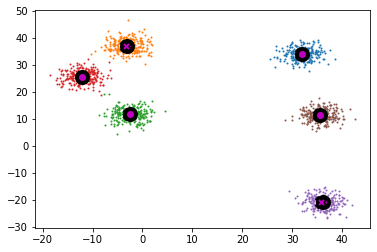

In [79]:
plot_data(centroids,clusters, data, n_samples)

In [101]:
data1 = data.cuda()
clusters1 = clusters.cuda()
%time clusters = k_means(data1,clusters1)

CPU times: user 606 µs, sys: 213 µs, total: 819 µs
Wall time: 615 µs


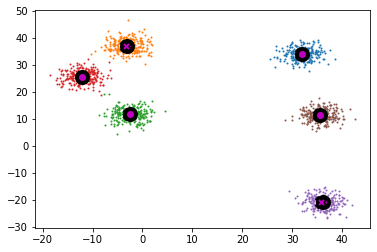

In [102]:
plot_data(centroids,clusters.cpu(), data, n_samples)